## Part I: Data Pre-processing

In [3]:
import pandas as pd

In [7]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2025-09-12 13:13:13--  http://download.tensorflow.org/data/questions-words.txt
正在查找主機 download.tensorflow.org (download.tensorflow.org)... 142.250.66.91, 142.250.204.59, 142.250.198.91, ...
正在連接 download.tensorflow.org (download.tensorflow.org)|142.250.66.91|:80... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 603955 (590K) [text/plain]
儲存到：「questions-words.txt」

questions-words.txt 100%[===================>] 589.80K  2.08MB/s  於 0.3s       

2025-09-12 13:13:13 (2.08 MB/s) - 已儲存 「questions-words.txt」 [603955/603955]



In [8]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [9]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [ ]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

In [12]:
import pandas as pd

questions = []
categories = []
sub_categories = []

with open("questions-words.txt", "r") as f:
    lines = f.readlines()

semantic_count = 0
syntactic_count = 0
current_category = None
current_type = None

for line in lines:
    line = line.strip()
    if line.startswith(":"):  # new section
        subcat = line[2:].strip()
        if semantic_count < 5:
            current_type = "semantic"
            semantic_count += 1
        else:
            current_type = "syntactic"
            syntactic_count += 1
        current_category = subcat
    else:
        if line:  # skip empty lines
            questions.append(line)
            categories.append(current_type)
            sub_categories.append(current_category)

# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

print(df.head())
print(df["Category"].value_counts())

                         Question  Category               SubCategory
0      Athens Greece Baghdad Iraq  semantic  capital-common-countries
1  Athens Greece Bangkok Thailand  semantic  capital-common-countries
2     Athens Greece Beijing China  semantic  capital-common-countries
3    Athens Greece Berlin Germany  semantic  capital-common-countries
4  Athens Greece Bern Switzerland  semantic  capital-common-countries
Category
syntactic    10675
semantic      8869
Name: count, dtype: int64


In [13]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [14]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,capital-common-countries
2,Athens Greece Beijing China,semantic,capital-common-countries
3,Athens Greece Berlin Germany,semantic,capital-common-countries
4,Athens Greece Bern Switzerland,semantic,capital-common-countries


In [15]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [18]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [19]:
data = pd.read_csv("questions-words.csv")

In [20]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 128.1/128.1MB downloaded
The Gensim model loaded successfully!


In [21]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      a, b, c, d = analogy.split()

      # 保留 gold answer
      golds.append(d)

      try:
            # vector arithmetic: b - a + c ≈ d
            pred = model.most_similar(
                  positive=[b, c],
                  negative=[a],
                  topn=1
            )[0][0]  # 取排名第一的詞
      except KeyError:
            # 有些詞可能不在 vocabulary 裡
            pred = None
      
      preds.append(pred)

# 現在 preds 和 golds 對應齊全，可以做 evaluation
print(preds[:10])
print(golds[:10])

100%|██████████| 19544/19544 [01:58<00:00, 164.83it/s] 

[None, None, None, None, None, None, None, None, None, None]
['Iraq', 'Thailand', 'China', 'Germany', 'Switzerland', 'Egypt', 'Australia', 'Vietnam', 'Cuba', 'Finland']


In [22]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 4.656669297553275%
Category: syntactic, Accuracy: 48.09367681498829%
Sub-Categorycapital-common-countries, Accuracy: 0.0%
Sub-Categorycapital-world, Accuracy: 0.0%
Sub-Categorycurrency, Accuracy: 0.0%
Sub-Categorycity-in-state, Accuracy: 0.0%
Sub-Categoryfamily, Accuracy: 81.62055335968378%
Sub-Categorygram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Categorygram2-opposite, Accuracy: 20.073891625615765%
Sub-Categorygram3-comparative, Accuracy: 79.12912912912913%
Sub-Categorygram4-superlative, Accuracy: 54.278074866310156%
Sub-Categorygram5-present-participle, Accuracy: 69.50757575757575%
Sub-Categorygram6-nationality-adjective, Accuracy: 0.0%
Sub-Categorygram7-past-tense, Accuracy: 55.44871794871795%
Sub-Categorygram8-plural, Accuracy: 71.996996996997%
Sub-Categorygram9-plural-verbs, Accuracy: 58.39080459770115%


In [31]:
print(data)

                             Question   Category               SubCategory
0          Athens Greece Baghdad Iraq   semantic  capital-common-countries
1      Athens Greece Bangkok Thailand   semantic  capital-common-countries
2         Athens Greece Beijing China   semantic  capital-common-countries
3        Athens Greece Berlin Germany   semantic  capital-common-countries
4      Athens Greece Bern Switzerland   semantic  capital-common-countries
...                               ...        ...                       ...
19539         write writes talk talks  syntactic        gram9-plural-verbs
19540       write writes think thinks  syntactic        gram9-plural-verbs
19541    write writes vanish vanishes  syntactic        gram9-plural-verbs
19542         write writes walk walks  syntactic        gram9-plural-verbs
19543         write writes work works  syntactic        gram9-plural-verbs

[19544 rows x 3 columns]


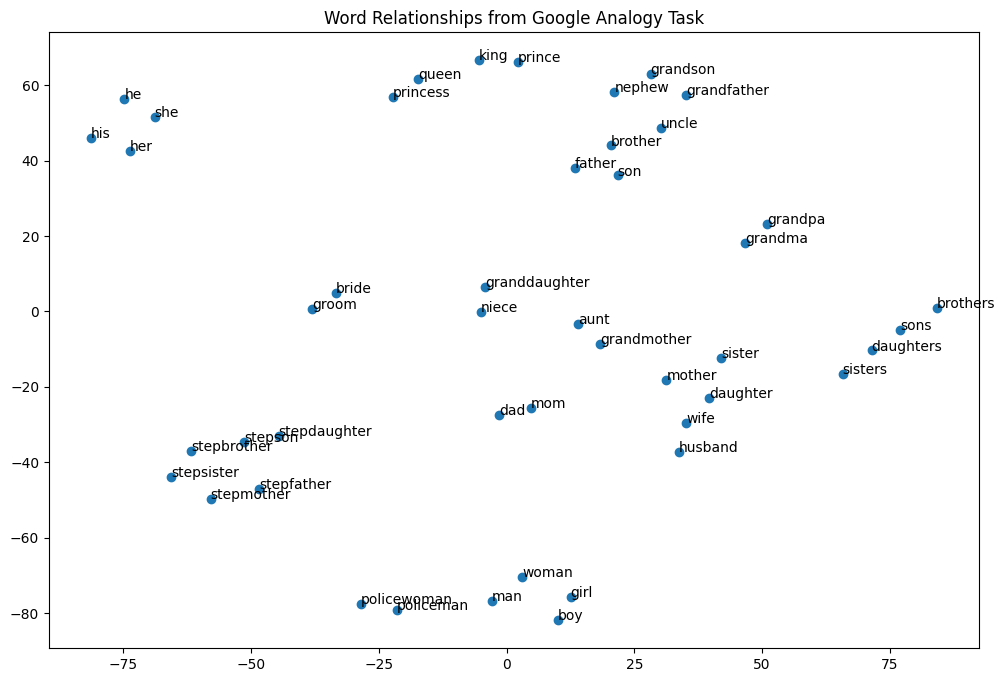

<Figure size 640x480 with 0 Axes>

In [35]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = "family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# 收集 family 類別下的所有詞
family_rows = df[df["SubCategory"] == SUB_CATEGORY]
words = set()
for q in family_rows["Question"]:
    a, b, c, d = q.split()
    words.update([a, b, c, d])
words = list(words)

# 過濾掉模型中不存在的詞
words_in_vocab = [w for w in words if w in model.key_to_index]

# 取 embeddings
X = np.array([model[w] for w in words_in_vocab])

# 用 t-SNE 降維
tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=5)
X_2d = tsne.fit_transform(X)
# 畫圖
plt.figure(figsize=(12, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1])

for i, word in enumerate(words_in_vocab):
    plt.annotate(word, (X_2d[i, 0], X_2d[i, 1]))

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [39]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/Users/bbb921921/Documents/github/DeepLearning/.conda/lib/python3.8/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=91b90d98-e49a-499b-8a34-c92f6affec49
To: /Users/bbb921921/Desktop/nlp/NTHU_Natural_Language_Processing/2025/Assignments/Assignment1/wiki_texts_part_0.txt.gz
  7%|██▋                                    | 102M/1.51G [00:08<01:37, 14.5MB/s]^C
  File "/Users/bbb921921/Documents/github/DeepLearning/.conda/lib/python3.8/site-packages/urllib3/response.py", line 873, in _raw_read
    data = self._fp_read(amt, read1=read1) if not fp_closed else b""
  File "/Users/bbb921921/Documents/github/DeepLearning/.conda/lib/python3.8/site-packages/urllib3

In [40]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/Users/bbb921921/Documents/github/DeepLearning/.conda/lib/python3.8/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=469d78d1-1fad-44f8-b166-79431b96f6f2
To: /Users/bbb921921/Desktop/nlp/NTHU_Natural_Language_Processing/2025/Assignments/Assignment1/wiki_texts_part_5.txt.gz
100%|████████████████████████████████████████| 578M/578M [00:41<00:00, 14.1MB/s]
/Users/bbb921921/Documents/github/DeepLearning/.conda/lib/python3.8/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://

In [41]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [43]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [44]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [45]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random
output_path = "wiki_texts_sampled.txt"
wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    sample_size = int(0.2 * len(lines))
    sampled_lines = random.sample(lines, sample_size)
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
    # 取樣 20%
        output_file.writelines(sampled_lines)

print(f"總共有 {len(lines)} 篇文章，取樣後保留 {len(sampled_lines)} 篇。")
print(f"已輸出到 {output_path}")

總共有 19558 篇文章，取樣後保留 3911 篇。
已輸出到 wiki_texts_sampled.txt


In [53]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# 取樣後的檔案
sampled_wiki_path = "wiki_texts_sampled.txt"

# Step 1: 前處理
sentences = []
with open(sampled_wiki_path, "r", encoding="utf-8") as f:
    for line in f:
        tokens = simple_preprocess(line)  # 斷詞 + 小寫化 + 去除標點符號
        if tokens:  # 確保不是空的
            sentences.append(tokens)

print(f"共收集到 {len(sentences)} 篇文章")

# Step 2: 訓練 Word2Vec
model = Word2Vec(
    sentences=sentences,
    vector_size=100,   # 向量維度，可以調大 (e.g. 300)
    window=5,          # 考慮的上下文大小
    min_count=2,       # 至少出現 5 次才保留
    workers=4,         # 使用的 CPU threads
    sg=1               # 1 = skip-gram, 0 = CBOW
)

# Step 3: 儲存模型
model.save("wiki_word2vec.model")
print("Word2Vec 訓練完成，模型已儲存到 wiki_word2vec.model")

共收集到 3911 篇文章
Word2Vec 訓練完成，模型已儲存到 wiki_word2vec.model


In [54]:
model.train(sentences, total_examples=len(sentences), epochs=10)

(152904, 156390)

In [55]:
model.wv.most_similar("king")

[('queen', 0.996120274066925),
 ('stepson', 0.9955339431762695),
 ('bride', 0.9953124523162842),
 ('groom', 0.9951297640800476),
 ('stepdaughter', 0.9950758218765259),
 ('her', 0.9942452907562256),
 ('son', 0.9928154349327087),
 ('his', 0.9924242496490479),
 ('daughter', 0.9923946857452393),
 ('nephew', 0.9916637539863586)]

In [56]:
data = pd.read_csv("questions-words.csv")

In [57]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      # 解析每個 analogy：word_a word_b word_c word_d
      try:
            word_a, word_b, word_c, word_d = analogy.split()
      except:
            continue  # 跳過格式錯誤的行
      
      # 保留 gold 答案
      golds.append(word_d)

      # 確保四個詞都在詞彙表內
      if all(w in model.wv for w in [word_a, word_b, word_c]):
            try:
                  # 做向量運算：word_b - word_a + word_c
                  result = model.wv.most_similar(
                  positive=[word_b, word_c],
                  negative=[word_a],
                  topn=1
                  )
                  # result 格式: [(pred_word, similarity)]
                  pred_word = result[0][0]
                  preds.append(pred_word)
            except KeyError:
                  preds.append(None)
      else:
            preds.append(None)

100%|██████████| 19544/19544 [00:01<00:00, 11046.68it/s]


In [58]:
correct = sum(1 for p, g in zip(preds, golds) if p == g)
accuracy = correct / len(golds)
print("Analogy Accuracy:", accuracy)

Analogy Accuracy: 0.12228817028243963


共找到 46 個有效詞： ['brothers', 'policeman', 'mom', 'wife', 'grandson', 'groom', 'sisters', 'brother', 'bride', 'stepfather', 'boy', 'he', 'prince', 'man', 'policewoman', 'husband', 'stepbrother', 'his', 'sister', 'mother']


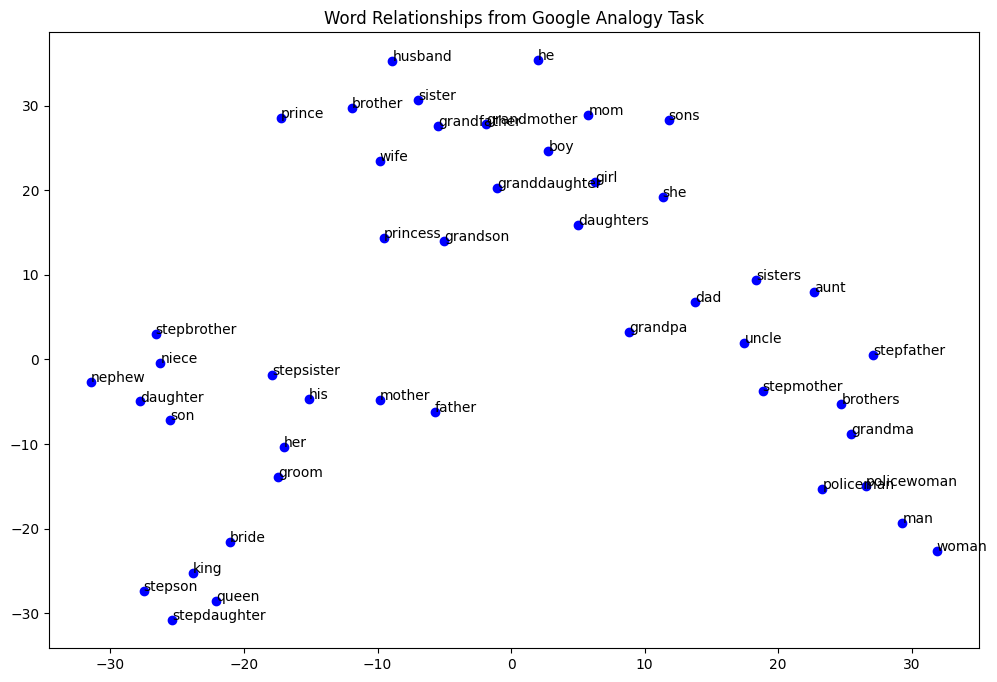

<Figure size 640x480 with 0 Axes>

In [61]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# 1. 選出 family 類別的資料
family_rows = df[df["SubCategory"] == "family"]

# 2. 收集 family 類別中出現的所有單字
words = set()
for q in family_rows["Question"]:
    words.update(q.split())

# 過濾掉不在模型詞彙表裡的單字
words = [w for w in words if w in model.wv]

print(f"共找到 {len(words)} 個有效詞：", words[:20])

# 3. 取出詞向量並轉成 numpy array
X = np.array([model.wv[w] for w in words])

# 4. 用 t-SNE 降維到 2D
tsne = TSNE(
    n_components=2,
    random_state=42,
    init="pca",
    perplexity=max(2, min(5, len(words)-1))
)
X_2d = tsne.fit_transform(X)

# 5. 畫圖
plt.figure(figsize=(12, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c="blue")

for i, word in enumerate(words):
    plt.annotate(word, (X_2d[i, 0], X_2d[i, 1]))
plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")